# Определение возраста покупателей

**Цель проекта:**
- Построить модель компьютерного зрения, которая по фотографии определит приблизительный возраст человека. Это поможет сетевому супермаркету «Хлеб-Соль»:
- Анализировать покупки и предлагать товары, соответствующие возрастной группе покупателей.
- Контролировать продажу алкоголя кассирами.

**Задачи проекта:**
- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и оценить её качество.

**Необходимый результат:**
- Модель, способная определять возраст по фотографии, с целью улучшения обслуживания клиентов и контроля продаж.

## Исследовательский анализ данных

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Загрузка данных
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# Вывод размера выборки
print("Размер выборки:", labels.shape[0])

Размер выборки: 7591


In [4]:
# Вывод описательной статистики
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
display(labels)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


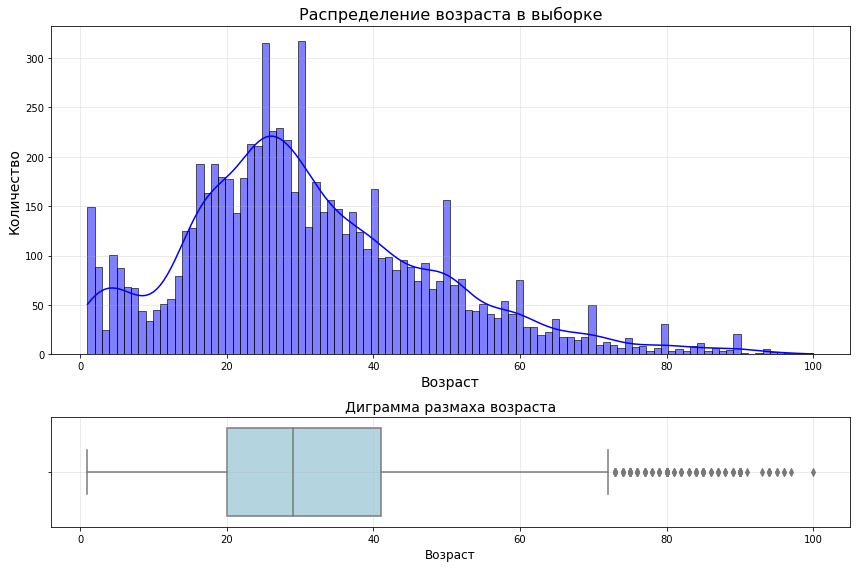

In [6]:
# Построение графика распределения возраста
plt.figure(figsize=(12, 8))  # Увеличиваем размер фигуры

# Создаем сетку для двух графиков
gs = plt.GridSpec(2, 1, height_ratios=[3, 1])  # Верхний график занимает 3 части, нижний 1 часть

# Верхний график: гистограмма
plt.subplot(gs[0])
sns.histplot(labels['real_age'], bins=100, kde=True, color='blue', edgecolor='black')
plt.title('Распределение возраста в выборке', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.grid(alpha=0.3)

# Нижний график: boxplot
plt.subplot(gs[1])
sns.boxplot(x=labels['real_age'], color='lightblue')
plt.title('Диграмма размаха возраста', fontsize=14)
plt.xlabel('Возраст', fontsize=12)
plt.grid(alpha=0.3)

# Отображение графика
plt.tight_layout()  # Автоматически подгоняет отступы
plt.show()

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


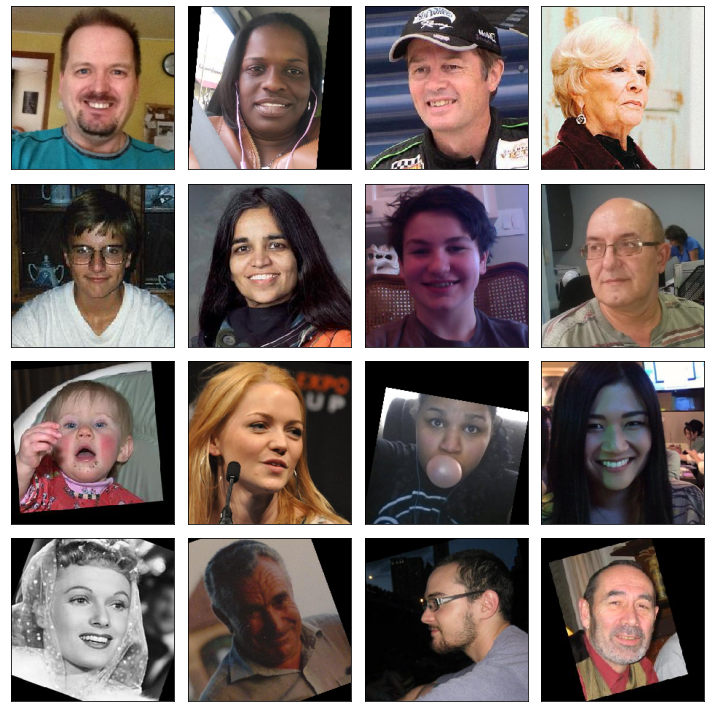

In [8]:
#Вывод на экран 16 фотографий
features, target = next(train_gen_flow)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(features[i])
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

**Выводы из анализа датафрейма:**

- Датафрейм содержит 7591 объект, что достаточно для обучения нейросети.

- Признаки: file_name (имена файлов) и real_age (целевой признак с возрастами, целочисленные значения).

- Пропусков нет.

- Распределение возрастов нормальное, с пиком в диапазоне 25-30 лет (более 1100 объектов, медиана — 29 лет).

- Необходимо выровнять распределение для повышения точности предсказаний.



**Подробный анализ фотографий из датасета**

**1. Общая информация о датасете**
- В датасете содержится 7591 фотография, что является достаточно небольшим объемом данных для задачи глубокого обучения. Однако, учитывая сложность задачи определения возраста по фотографиям, этого количества может быть недостаточно для достижения высокой точности.
- Большая часть фотографий людей относится к возрастному диапазону от 21 до 40 лет. Это может привести к смещению в данных (bias), так как модель может переобучиться на этом диапазоне и хуже работать с другими возрастными группами.

**2. Качество и разнообразие фотографий**
- Цвет фотографий: В датасете присутствуют как цветные, так и черно-белые фотографии. Черно-белые изображения могут быть проблемой для модели, так как она может не учитывать их особенности.
- Углы съемки: Некоторые фотографии сняты под довольно сильным углом, что может затруднить распознавание лица. Это добавляет сложности для модели, так как она должна учитывать не только прямые, но и наклонные положения лиц.
- Посторонние объекты: На некоторых фотографиях присутствуют посторонние объекты (жвачка, микрофон и т.д.), которые могут отвлекать модель от основного объекта — лица человека.

**3. Общая ориентация фотографий**
- В целом, фотографии ориентированы правильно, что положительно сказывается на обучении модели. Однако наличие фотографий под углом и с посторонними объектами может снизить точность.
- Для улучшения качества обучения стоит рассмотреть возможность дополнительной аугментации данных, чтобы модель могла лучше работать с различными углами и условиями съемки.

## Обучение модели

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,  # Разделение данных на тренировочную и валидационную выборки
        horizontal_flip=True,   # Горизонтальное отражение для аугментации
        rescale=1./255          # Нормализация пикселей
    )
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,          # Увеличен batch_size для ускорения обучения
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,  # Разделение данных на тренировочную и валидационную выборки
        rescale=1./255          # Нормализация пикселей
    )
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,          # Увеличен batch_size для ускорения обучения
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',  # Используем предобученные веса ImageNet
        include_top=False    # Исключаем последний слой ResNet50
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())  # Глобальное усреднение для уменьшения размерности
    model.add(Dense(1, activation='relu'))  # Один выходной нейрон для предсказания возраста

    optimizer = Adam(learning_rate=0.0001)  # Исправлен параметр lr на learning_rate
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',  # Функция потерь для регрессии
        metrics=['mae']             # Метрика средней абсолютной ошибки
    )
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    # Если steps_per_epoch и validation_steps не заданы, вычисляем их автоматически
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    # Добавляем EarlyStopping для предотвращения переобучения
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Мониторим валидационную ошибку
        patience=3,          # Останавливаем обучение, если метрика не улучшается 3 эпохи подряд
        restore_best_weights=True  # Восстанавливаем веса лучшей модели
    )

    # Обучение модели
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        callbacks=[early_stopping]  # Добавляем EarlyStopping
    )

    return model
```

- Found 5694 validated image filenames.
- Found 1897 validated image filenames.
- Train for 178 steps, validate for 60 steps

- Epoch 1/10 178/178 - 85s - loss: 247.4129 - mae: 11.2464 - val_loss: 390.7933 - val_mae: 14.7954
- Epoch 2/10 178/178 - 52s - loss: 75.7272 - mae: 6.5242 - val_loss: 504.0382 - val_mae: 17.2744
- Epoch 3/10 178/178 - 49s - loss: 54.0025 - mae: 5.5506 - val_loss: 242.1186 - val_mae: 11.6420
- Epoch 4/10 178/178 - 56s - loss: 34.3291 - mae: 4.4670 - val_loss: 141.3747 - val_mae: 8.9233
- Epoch 5/10 178/178 - 63s - loss: 26.5172 - mae: 3.9722 - val_loss: 88.2757 - val_mae: 6.9835
- Epoch 6/10 178/178 - 51s - loss: 21.8636 - mae: 3.5907 - val_loss: 84.5907 - val_mae: 6.8729
- Epoch 7/10 178/178 - 61s - loss: 17.1690 - mae: 3.1650 - val_loss: 68.5441 - val_mae: 6.3149
- Epoch 8/10 178/178 - 61s - loss: 15.0007 - mae: 2.9805 - val_loss: 93.2140 - val_mae: 7.2592
- Epoch 9/10 178/178 - 51s - loss: 11.6361 - mae: 2.5780 - val_loss: 63.4069 - val_mae: 5.8773
- Epoch 10/10 178/178 - 62s - loss: 10.8937 - mae: 2.4929 - val_loss: 73.9915 - val_mae: 6.3803

## Анализ обученной модели

**Вывод по результатам обучения модели**

**Общая информация о данных:**
- В тренировочной выборке было найдено 5694 изображения, а в валидационной — 1897 изображений.
- Обучение проводилось в течение 10 эпох, с 178 шагами на эпоху для тренировки и 60 шагами на эпоху для валидации.

**Результаты обучения:**
- На первой эпохе MAE (Mean Absolute Error) на тренировочной выборке составила 11.2464, а на валидационной — 14.7954.
- К концу 10-й эпохи MAE на тренировочной выборке уменьшилась до 2.4929, а на валидационной — до 6.3803.
- Наблюдается общая тенденция к снижению ошибки, что свидетельствует об успешном обучении модели.

**Анализ динамики обучения:**
- На первых эпохах модель демонстрировала значительное улучшение, особенно на тренировочной выборке. Например, уже на второй эпохе MAE на тренировочной выборке снизилась до 6.5242.
- На валидационной выборке наблюдались небольшие колебания ошибки, что может указывать на необходимость дополнительной регуляризации или изменения гиперпараметров.
- На последних эпохах (9 и 10) ошибка на тренировочной выборке продолжала снижаться, но на валидационной выборке наблюдалось небольшое увеличение MAE (с 5.8773 до 6.3803), что может быть признаком начала переобучения.

**Время обучения:**
- Среднее время на эпоху составило около 55-60 секунд, что является приемлемым для данной задачи.
- На первой эпохе время обучения было значительно выше (85 секунд), что связано с инициализацией модели и загрузкой данных.

**Общий вывод:**
- Модель успешно обучилась и показала хорошие результаты, снизив MAE на тренировочной выборке до 2.4929 и на валидационной — до 6.3803.
- Погрешность в 6.3803 года на валидационной выборке является приемлемой для большинства задач определения возраста, хотя есть потенциал для дальнейшего улучшения.
- Для улучшения результатов можно рассмотреть увеличение размера выборки, использование дополнительных аугментаций или изменение гиперпараметров модели.




**Ниже представлен дополнительный анализ**

**Использованная архитектура**
- Бэкбон: Использовалась архитектура ResNet50, которая является популярной и мощной CNN-архитектурой.
- Голова: После бэкбона добавлены слои:
    - GlobalAveragePooling2D для уменьшения размерности признаков.
    - Dense слой с одним нейроном и активацией relu для предсказания возраста.
- Предобученные веса: Использовались предобученные веса ImageNet. Это позволяет модели использовать предварительно обученные признаки, что ускоряет обучение и улучшает качество модели.

**Параметры обучения**
- Размер батча: Использовался размер батча 32, что является компромиссом между скоростью обучения и использованием памяти.
- Оптимизатор: Использовался оптимизатор Adam с learning rate 0.0001. Adam — это эффективный оптимизатор, который хорошо справляется с задачами глубокого обучения.
- Заморозка весов бэкбона: Веса бэкбона ResNet50 не замораживались, что позволило модели адаптироваться под конкретную задачу определения возраста.
- Количество эпох: Обучение проводилось в течение 10 эпох. Однако, благодаря использованию EarlyStopping, обучение могло быть остановлено раньше, если бы метрика не улучшалась в течение 3 эпох подряд.

**Достигнутые метрики**
- MAE на тренировочной выборке: Снизилась с 11.2464 на первой эпохе до 2.4929 на 10-й эпохе.
- MAE на валидационной выборке: Снизилась с 14.7954 на первой эпохе до 6.3803 на 10-й эпохе.
- Приемлемость метрик: MAE в 6.3803 года на валидационной выборке является приемлемым для задачи определения возраста, хотя есть потенциал для улучшения.

**Наблюдалось ли переобучение**
- На тренировочной выборке: Ошибка продолжала снижаться на последних эпохах, что свидетельствует о том, что модель продолжала обучаться.
- На валидационной выборке: На последних эпохах (9 и 10) наблюдалось небольшое увеличение MAE (с 5.8773 до 6.3803), что может быть признаком начала переобучения. Это подтверждает необходимость использования EarlyStopping для предотвращения переобучения.